In [1]:
!pip install numpy scipy librosa soundfile noisereduce scikit-learn joblib pydub SpeechRecognition matplotlib seaborn
!pip install git+https://github.com/openai/whisper.git


  Cloning https://github.com/openai/whisper.git to c:\users\vedan\appdata\local\temp\pip-req-build-vn_uuzzh
  Resolved https://github.com/openai/whisper.git to commit c0d2f624c09dc18e709e37c2ad90c039a4eb72a2
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git 'C:\Users\vedan\AppData\Local\Temp\pip-req-build-vn_uuzzh'


In [2]:
import os
import json
import numpy as np
import librosa
import noisereduce as nr
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import whisper
import speech_recognition as sr


In [3]:
# Folders containing WAV files
real_folder = "data/real"
fake_folder = "data/fake"

# Model output path
model_path = "models/rf_model.joblib"
os.makedirs("models", exist_ok=True)

# Keywords to flag
keywords = ["password", "transfer", "bank", "login","kyc","otp","urgent","fast","emergency","password", "transfer", "bank", "login", "kyc", "otp", "urgent", "fast", "emergency", "verify", "verification", "instant", "winner", "congratulations", "prize", "reward", "refund", "blocked", "suspended", "account", "payment", "transaction", "secure", "authentication", "code", "PIN", "confirm", "update", "redeem", "claim", "exclusive", "limited", "final notice", "act now", "install", "update app", "support", "tech support", "remote access", "screen share", "malware", "suspicious", "penalty", "court", "tax", "income tax", "aadhaar", "PAN", "police", "freeze","alert", "security", "locked", "unlock", "reset", "reactivate", "loan", "EMI", "credit", "debit", "offer", "bonus", "gift", "cashback", "discount", "deal", "limited offer", "exclusive offer", "last chance", "final warning", "confirm identity", "access", "link", "click", "tap", "download", "app", "install now", "helpdesk", "customer care", "service center", "payment failed", "insufficient balance", "verify now", "kyc update", "bank verification", "identity proof", "pan verification", "aadhaar update", "government", "official", "RBI", "income tax department", "cyber cell", "legal action", "lawsuit", "fine", "warning", "risk", "scam alert", "fraud", "fake", "limited time"]


In [4]:
def load_audio(file_path, sr=16000):
    y, _ = librosa.load(file_path, sr=sr)
    y_denoised = nr.reduce_noise(y=y, sr=sr)
    return y_denoised


In [5]:
def extract_features(y, sr=16000, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs, axis=1)

    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    rms = np.mean(librosa.feature.rms(y=y))

    features = np.hstack([mfccs_mean, spectral_centroid, spectral_bandwidth, rms])
    return features


In [6]:
X, y_labels = [], []

# Real audio
for file in os.listdir(real_folder):
    if file.endswith(".wav"):
        y_audio = load_audio(os.path.join(real_folder, file))
        feats = extract_features(y_audio)
        X.append(feats)
        y_labels.append(0)  # Real

# Fake audio
for file in os.listdir(fake_folder):
    if file.endswith(".wav"):
        y_audio = load_audio(os.path.join(fake_folder, file))
        feats = extract_features(y_audio)
        X.append(feats)
        y_labels.append(1)  # Fake

X = np.array(X)
y_labels = np.array(y_labels)
print("Dataset shape:", X.shape, y_labels.shape)


Dataset shape: (60645, 16) (60645,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size=0.2, random_state=42, stratify=y_labels)


In [8]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Save model
joblib.dump(clf, model_path)
print("Model trained and saved at", model_path)


Model trained and saved at models/rf_model.joblib


In [9]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {acc:.3f}, F1-score: {f1:.3f}, AUC: {auc:.3f}")


Accuracy: 0.945, F1-score: 0.963, AUC: 0.985


In [10]:
# Load Whisper model once for transcription
whisper_model = whisper.load_model("base")  # or "tiny" for faster inference


In [11]:
def transcribe_audio(file_path, use_whisper=True):
    if use_whisper:
        result = whisper_model.transcribe(file_path)
        transcript = result["text"]
    else:
        r = sr.Recognizer()
        with sr.AudioFile(file_path) as source:
            audio_data = r.record(source)
            transcript = r.recognize_google(audio_data)
    return transcript


In [12]:
def predict_audio_realSTT(file_path, clf_model, keywords_list=keywords, use_whisper=True):
    y_audio = load_audio(file_path)
    feats = extract_features(y_audio).reshape(1, -1)

    proba_fake = clf_model.predict_proba(feats)[0][1]
    label = "Fake" if proba_fake > 0.5 else "Real"

    # Real transcript
    transcript = transcribe_audio(file_path, use_whisper=use_whisper)

    # Keyword detection
    flagged_keywords = [k for k in keywords_list if k.lower() in transcript.lower()]

    # Risk score = fake probability + 0.2 per flagged keyword (capped at 1.0)
    risk_score = min(proba_fake + 0.2*len(flagged_keywords), 1.0)

    alerts = []
    if risk_score > 0.7:
        alerts.append("HIGH RISK")
    elif risk_score > 0.4:
        alerts.append("MEDIUM RISK")
    else:
        alerts.append("LOW RISK")

    report = {
        "file": file_path,
        "transcript": transcript,
        "prediction": label,
        "fake_probability": float(proba_fake),
        "risk_score": float(risk_score),
        "alerts": alerts,
        "keywords_found": flagged_keywords
    }

    # Save JSON report
    report_path = file_path.replace(".wav", ".report.json")
    with open(report_path, "w") as f:
        json.dump(report, f, indent=4)

    # Friendly readable summary
    print(f"\n--- Deepfake Audio Detection Report ---")
    print(f"File: {file_path}")
    print(f"Prediction: {label}")
    print(f"Fake Probability: {proba_fake:.2f}")
    print(f"Risk Score: {risk_score:.2f} → {' , '.join(alerts)}")
    print(f"Transcript: {transcript}")
    if flagged_keywords:
        print(f"Keywords flagged: {', '.join(flagged_keywords)}")
    else:
        print("Keywords flagged: None")

    return report


In [13]:
!ffmpeg -version


ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
built with gcc 10.2.1 (GCC) 20200726
configuration: --disable-static --enable-shared --enable-gpl --enable-version3 --enable-sdl2 --enable-fontconfig --enable-gnutls --enable-iconv --enable-libass --enable-libdav1d --enable-libbluray --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libsrt --enable-libtheora --enable-libtwolame --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libzimg --enable-lzma --enable-zlib --enable-gmp --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvo-amrwbenc --enable-libmysofa --enable-libspeex --enable-libxvid --enable-libaom --enable-libgsm --enable-librav1e --disable-w32threads --enable-libmfx --enable-ffnvcodec --enable-cuda-llvm --enable-cuvid --enable-d3d11va --en

In [14]:
from pydub import AudioSegment
try:
    audio = AudioSegment.from_wav("test.wav")
    print("✅ FFmpeg is working! Audio loaded successfully.")
except Exception as e:
    print("❌ Something’s still wrong:", e)


✅ FFmpeg is working! Audio loaded successfully.


In [15]:
import speech_recognition as sr

def transcribe_audio(file_path, use_whisper=False):
    if use_whisper:
        import whisper
        model = whisper.load_model("base")
        result = model.transcribe(file_path)
        return result["text"]

    r = sr.Recognizer()
    with sr.AudioFile(file_path) as source:
        audio_data = r.record(source)
    try:
        transcript = r.recognize_google(audio_data)
    except sr.UnknownValueError:
        transcript = ""  # Could not understand audio
    except sr.RequestError:
        transcript = "[ERROR: API unavailable]"
    return transcript


In [16]:
from pydub import AudioSegment, effects

def clean_audio(input_path, output_path="cleaned.wav"):
    audio = AudioSegment.from_file(input_path)
    audio = audio.set_channels(1)  # mono
    audio = audio.set_frame_rate(16000)  # standard STT rate
    audio = effects.normalize(audio)  # volume normalization
    audio.export(output_path, format="wav")
    return output_path


In [17]:
file_path = clean_audio("test_clean.wav")
predict_audio_realSTT(file_path, clf, use_whisper=False)



--- Deepfake Audio Detection Report ---
File: cleaned.wav
Prediction: Fake
Fake Probability: 0.58
Risk Score: 0.58 → MEDIUM RISK
Transcript: the most useful thing that I can actually help for useful to you in the future and I thought came to be here
Keywords flagged: None


{'file': 'cleaned.wav',
 'transcript': 'the most useful thing that I can actually help for useful to you in the future and I thought came to be here',
 'prediction': 'Fake',
 'fake_probability': 0.58,
 'risk_score': 0.58,
 'alerts': ['MEDIUM RISK'],
 'keywords_found': []}

In [18]:
predict_audio_realSTT("test_clean.wav", clf, use_whisper=True)


C:\ProgramData\anaconda3\Lib\site-packages\whisper\transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")



--- Deepfake Audio Detection Report ---
File: test_clean.wav
Prediction: Fake
Fake Probability: 0.70
Risk Score: 0.70 → MEDIUM RISK
Transcript:  description. So I thought I was trying to think what is the most useful thing that I could work with, I say that could actually be helpful or useful to you in the future. And I thought perhaps tell the story of how I sort of came to be here, how did some of these things happen and maybe there's some lessons there. Because I often find myself wondering how did this happen. So what when is...
Keywords flagged: None


{'file': 'test_clean.wav',
 'transcript': " description. So I thought I was trying to think what is the most useful thing that I could work with, I say that could actually be helpful or useful to you in the future. And I thought perhaps tell the story of how I sort of came to be here, how did some of these things happen and maybe there's some lessons there. Because I often find myself wondering how did this happen. So what when is...",
 'prediction': 'Fake',
 'fake_probability': 0.7,
 'risk_score': 0.7,
 'alerts': ['MEDIUM RISK'],
 'keywords_found': []}

In [19]:
from pydub import AudioSegment

# Convert to clean PCM WAV under 30 seconds
audio = AudioSegment.from_file("test.wav")
audio = audio.set_frame_rate(16000).set_channels(1)
audio[:29000].export("test_clean.wav", format="wav")

# Now test again
predict_audio_realSTT("test_clean.wav", clf, use_whisper=False)



--- Deepfake Audio Detection Report ---
File: test_clean.wav
Prediction: Fake
Fake Probability: 0.70
Risk Score: 0.70 → MEDIUM RISK
Transcript: the most useful thing that I can actually help for useful in the future and I thought came to be here
Keywords flagged: None


{'file': 'test_clean.wav',
 'transcript': 'the most useful thing that I can actually help for useful in the future and I thought came to be here',
 'prediction': 'Fake',
 'fake_probability': 0.7,
 'risk_score': 0.7,
 'alerts': ['MEDIUM RISK'],
 'keywords_found': []}

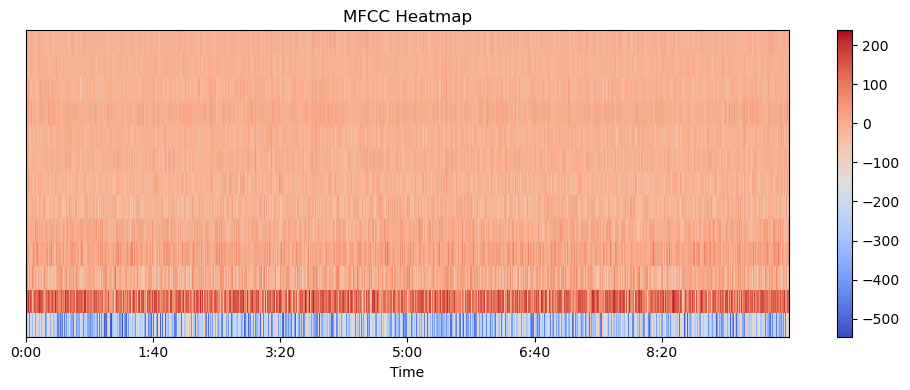

In [21]:
import librosa.display
import matplotlib.pyplot as plt
y, sr = librosa.load("test.wav")
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
plt.figure(figsize=(10,4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC Heatmap')
plt.tight_layout()
plt.show()


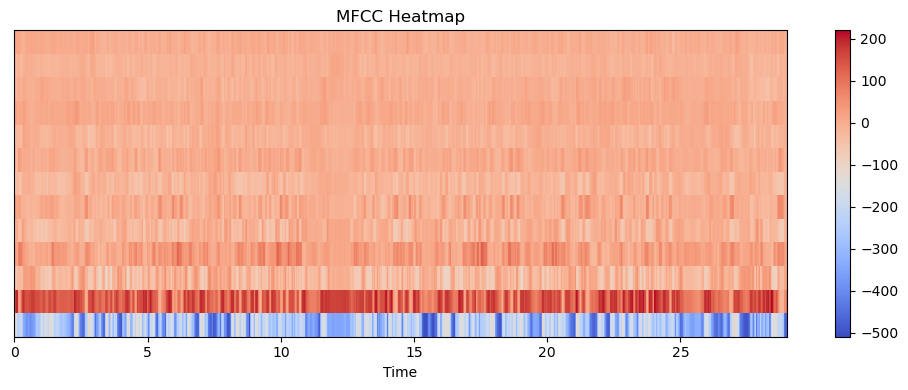

In [22]:
import librosa.display
import matplotlib.pyplot as plt
y, sr = librosa.load("test_clean.wav")
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
plt.figure(figsize=(10,4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC Heatmap')
plt.tight_layout()
plt.show()


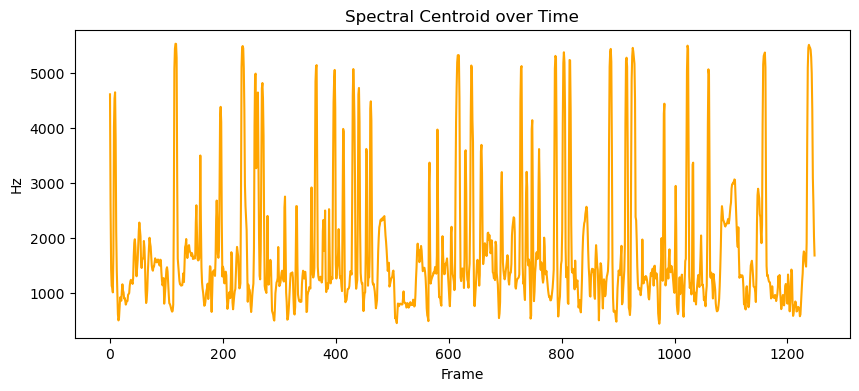

In [23]:
spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
plt.figure(figsize=(10,4))
plt.plot(spectral_centroids, color='orange')
plt.title("Spectral Centroid over Time")
plt.xlabel("Frame")
plt.ylabel("Hz")
plt.show()


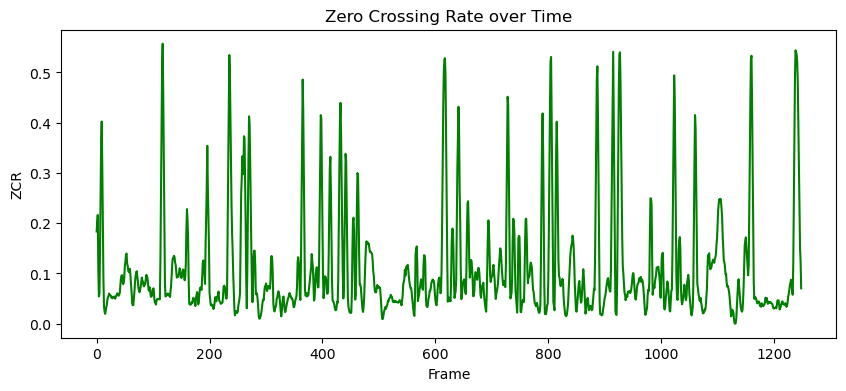

In [24]:
zcr = librosa.feature.zero_crossing_rate(y)
plt.figure(figsize=(10,4))
plt.plot(zcr[0], color='green')
plt.title("Zero Crossing Rate over Time")
plt.xlabel("Frame")
plt.ylabel("ZCR")
plt.show()


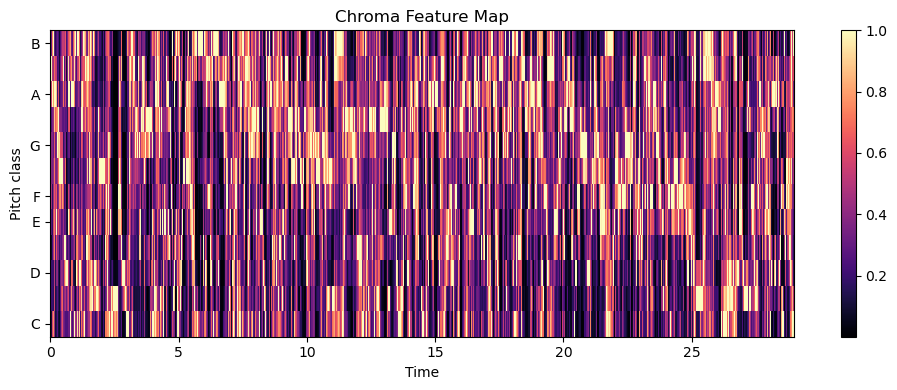

In [25]:
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
plt.figure(figsize=(10,4))
librosa.display.specshow(chroma, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title('Chroma Feature Map')
plt.tight_layout()
plt.show()


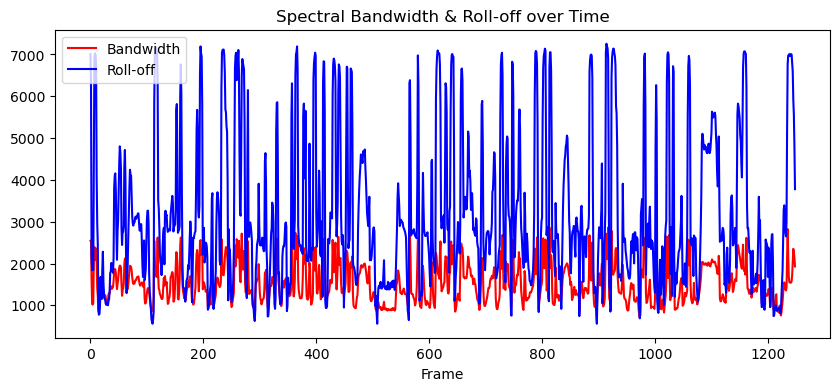

In [26]:
bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]

plt.figure(figsize=(10,4))
plt.plot(bandwidth, label='Bandwidth', color='red')
plt.plot(rolloff, label='Roll-off', color='blue')
plt.title("Spectral Bandwidth & Roll-off over Time")
plt.xlabel("Frame")
plt.legend()
plt.show()


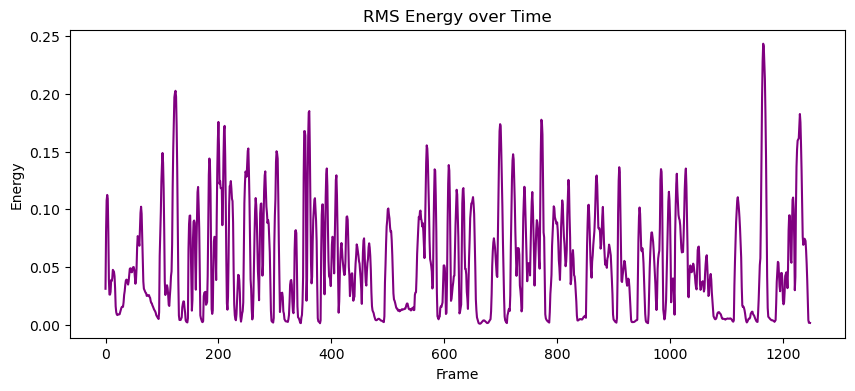

In [27]:
rms = librosa.feature.rms(y=y)[0]
plt.figure(figsize=(10,4))
plt.plot(rms, color='purple')
plt.title("RMS Energy over Time")
plt.xlabel("Frame")
plt.ylabel("Energy")
plt.show()


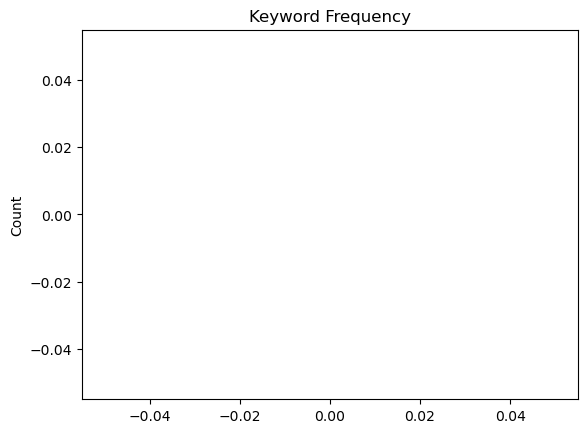

In [30]:
from collections import Counter
import matplotlib.pyplot as plt
keywords = ["password", "transfer", "bank", "login","kyc","otp","urgent","fast","emergency","password", "transfer", "bank", "login", "kyc", "otp", "urgent", "fast", "emergency", "verify", "verification", "instant", "winner", "congratulations", "prize", "reward", "refund", "blocked", "suspended", "account", "payment", "transaction", "secure", "authentication", "code", "PIN", "confirm", "update", "redeem", "claim", "exclusive", "limited", "final notice", "act now", "install", "update app", "support", "tech support", "remote access", "screen share", "malware", "suspicious", "penalty", "court", "tax", "income tax", "aadhaar", "PAN", "police", "freeze","alert", "security", "locked", "unlock", "reset", "reactivate", "loan", "EMI", "credit", "debit", "offer", "bonus", "gift", "cashback", "discount", "deal", "limited offer", "exclusive offer", "last chance", "final warning", "confirm identity", "access", "link", "click", "tap", "download", "app", "install now", "helpdesk", "customer care", "service center", "payment failed", "insufficient balance", "verify now", "kyc update", "bank verification", "identity proof", "pan verification", "aadhaar update", "government", "official", "RBI", "income tax department", "cyber cell", "legal action", "lawsuit", "fine", "warning", "risk", "scam alert", "fraud", "fake", "limited time"]
transcript = "your recognized speech text"
counts = Counter([word for word in transcript.split() if word.lower() in keywords])

plt.bar(counts.keys(), counts.values(), color='teal')
plt.title("Keyword Frequency")
plt.ylabel("Count")
plt.show()
